In [91]:
#general package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy import stats

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

import random
import tensorflow as tf 

In [92]:
# historical full-time dataframe
df_bat = pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/halftime_encode_python.csv')
df_bat

columns_to_keep = ['Result', "match_number", "team_code", "opponent_code", 
                   "gender", 'season', 'home_advantage', 'venue_city_code',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df = df_bat[columns_to_keep]

X_train = df.drop("Result", axis=1)
y_train = df['Result']

In [93]:
X_train.head()

,match_number,team_code,opponent_code,gender,season,home_advantage,venue_city_code,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,5,4,1,0,2021,0,1,139.0,1.0,5.0,1
1,6,0,2,0,2021,0,2,128.0,0.0,6.0,0
2,7,3,6,0,2021,0,6,131.0,1.0,4.0,1
3,8,7,5,0,2021,1,5,130.0,0.0,8.0,0
4,10,6,1,0,2021,0,1,116.0,0.0,7.0,0


In [94]:
df.shape

(115, 12)

In [95]:
#new prediction dataset
df_2023_full = pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/prediction_set_encoding_fulltime_model.csv')

In [96]:
df_2023_full.shape

(58, 12)

In [97]:
X_new_season_full = df_2023_full.drop("Result", axis=1)
y_new_season_full = df_2023_full['Result']

In [98]:
X_new_season_full.head()

,match_number,team_code,opponent_code,gender,season,home_advantage,venue_city_code,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,1,5,6,0,2023,0,6,121.941176,0.764706,5.000000,0
1,4,0,3,0,2023,0,3,124.533333,0.466667,6.400000,0
2,5,7,5,0,2023,0,5,118.857143,0.214286,6.785714,0
3,8,3,5,0,2023,0,5,128.428571,0.500000,5.000000,1
4,9,4,7,0,2023,1,7,118.437500,0.750000,4.687500,1


## Full-time models

In [99]:
## Step 1: Feature scaling
# Use the same scaler trained on the historical data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_new_season_full_scaled = scaler.transform(X_new_season_full)  

In [100]:
# Set random seeds
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

### 1. KNN (K-Nearest Neighbors)

In [101]:
#Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}

# Train the model on historical data
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='uniform')
knn.fit(X_train_scaled, y_train)

# Apply the model to the new season data
y_prob_new_season_knn = knn.predict_proba(X_new_season_full_scaled)[:, 1]
y_pred_new_season_knn = (y_prob_new_season_knn > 0.5).astype(int)

print("Predicted Probabilities for KNN in 2023 new season:")
print(y_prob_new_season_knn)

Predicted Probabilities for KNN in 2023 new season:
[0.5 0.5 0.3 0.4 0.6 0.5 0.3 0.5 0.7 0.6 0.6 0.5 0.4 0.6 0.6 0.4 0.4 0.6
 0.3 0.5 0.6 0.5 0.3 0.4 0.6 0.7 0.6 0.5 0.4 0.6 0.5 0.5 0.6 0.5 0.6 0.5
 0.4 0.7 0.3 0.5 0.3 0.5 0.5 0.4 0.3 0.5 0.5 0.5 0.4 0.5 0.6 0.6 0.3 0.6
 0.4 0.3 0.3 0.3]


In [102]:
y_pred_new_season_knn

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0])

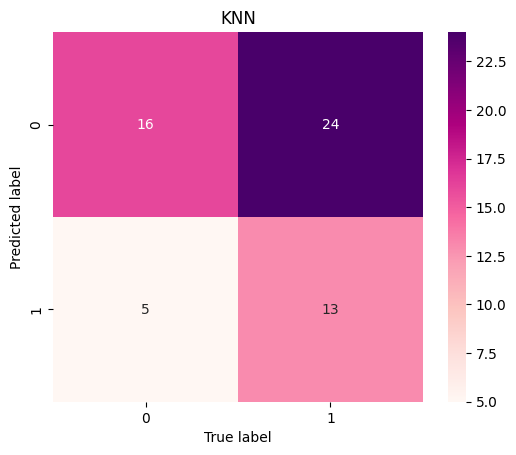

Accuracy:	0.500000
F1-score:	0.498659
Precision:	0.561111
Recall:		0.556628

Classification performance:
              precision    recall  f1-score   support

           0       0.40      0.76      0.52        21
           1       0.72      0.35      0.47        37

    accuracy                           0.50        58
   macro avg       0.56      0.56      0.50        58
weighted avg       0.61      0.50      0.49        58



In [103]:
mat_knn = confusion_matrix(y_new_season_full, y_pred_new_season_knn)
sns.heatmap(mat_knn.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y_new_season_full, y_pred_new_season_knn))
print("F1-score:\t%f" % f1_score(y_new_season_full, y_pred_new_season_knn, average='macro'))
print("Precision:\t%f" % precision_score(y_new_season_full, y_pred_new_season_knn, average='macro'))
print("Recall:\t\t%f" % recall_score(y_new_season_full, y_pred_new_season_knn, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_new_season_full, y_pred_new_season_knn))

### 2. SVM (Support Vector Machine) 

In [104]:
#Best parameters for SVM: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}

#Train the model on historical data
svm = SVC(C=1000, gamma='scale', kernel='linear', probability=True)
svm.fit(X_train_scaled, y_train)

#Apply the model to the new season data
y_prob_new_season_svm = svm.predict_proba(X_new_season_full_scaled)[:, 1]
y_pred_new_season_svm = (y_prob_new_season_svm > 0.5).astype(int)

print("Predicted Probabilities for SVM in 2023 season:")
print(y_prob_new_season_svm)

Predicted Probabilities for SVM in 2023 season:
[0.4834937  0.47317344 0.39563038 0.52732067 0.5442009  0.46132512
 0.51375136 0.50724488 0.5485693  0.39086308 0.53711953 0.50916482
 0.41292352 0.53196453 0.5        0.40995354 0.48377425 0.47389235
 0.50997093 0.5        0.45157931 0.51393698 0.48551804 0.40855662
 0.53645559 0.5        0.52780839 0.447497   0.42955455 0.5
 0.43293416 0.48702834 0.51291117 0.45281653 0.48369952 0.45694031
 0.45668691 0.52641976 0.42917301 0.5        0.43876629 0.46462931
 0.51569017 0.43172554 0.46262197 0.48362843 0.46556484 0.48739848
 0.44381906 0.44404286 0.48050804 0.46462377 0.4212053  0.46597338
 0.47504699 0.47644685 0.44264637 0.40579589]


In [105]:
y_pred_new_season_svm

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

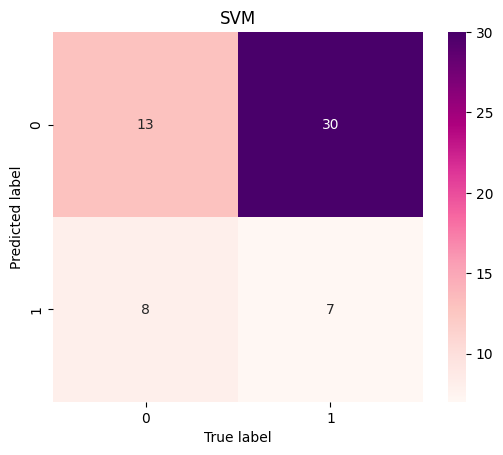

Accuracy:	0.344828
F1-score:	0.337740
Precision:	0.384496
Recall:		0.404118

Classification performance:
              precision    recall  f1-score   support

           0       0.30      0.62      0.41        21
           1       0.47      0.19      0.27        37

    accuracy                           0.34        58
   macro avg       0.38      0.40      0.34        58
weighted avg       0.41      0.34      0.32        58



In [106]:
mat_svm = confusion_matrix(y_new_season_full, y_pred_new_season_svm)
sns.heatmap(mat_svm.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y_new_season_full, y_pred_new_season_svm))
print("F1-score:\t%f" % f1_score(y_new_season_full, y_pred_new_season_svm, average='macro'))
print("Precision:\t%f" % precision_score(y_new_season_full, y_pred_new_season_svm, average='macro'))
print("Recall:\t\t%f" % recall_score(y_new_season_full, y_pred_new_season_svm, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_new_season_full, y_pred_new_season_svm))

### 3. Deep Netural Networks

In [107]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [108]:
##Best parameters found:  {'activation': 'tanh', 'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 100}

# Define the model with the optimal parameters
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=11, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train the model on full historical data
model = create_model()
model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)

# Apply the model to the new season data
y_prob_new_season_dnn = model.predict(X_new_season_full_scaled).flatten()
y_pred_new_season_dnn = (y_prob_new_season_dnn > 0.5).astype(int)

# Evaluate the model
print("DNN Model")
print("Predicted Probabilities in 2023 new season:")
print(y_prob_new_season_dnn)

2/2 [==============================] - 0s 971us/step
DNN Model
Predicted Probabilities in 2023 new season:
[0.6960218  0.5420688  0.28988007 0.3951668  0.9387406  0.5774546
 0.65514046 0.4949885  0.83663034 0.53395486 0.6943437  0.87262744
 0.43718442 0.51006895 0.55750895 0.6285767  0.48912817 0.4039983
 0.5454899  0.4333421  0.41050348 0.7217647  0.47882882 0.4098263
 0.9424601  0.8976742  0.789129   0.571554   0.40883845 0.66201854
 0.50303966 0.49387544 0.83633286 0.28698918 0.39703828 0.23329926
 0.351877   0.8448614  0.35661545 0.7240012  0.45131877 0.39834213
 0.71765196 0.4257146  0.42904374 0.44485706 0.27858073 0.51777476
 0.3565858  0.22178306 0.46437347 0.28786013 0.22151193 0.6837665
 0.6756104  0.43056396 0.40620828 0.35341883]


In [78]:
y_pred_new_season_dnn

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

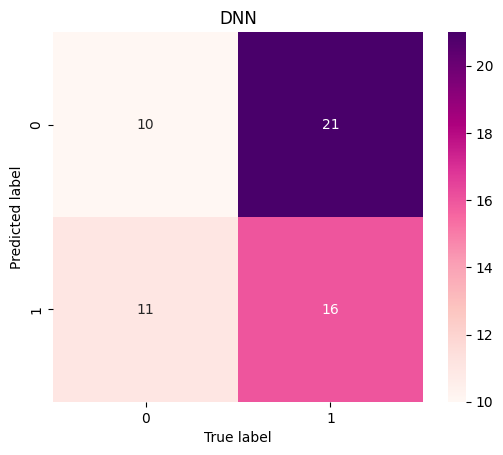

Accuracy:	0.448276
F1-score:	0.500000
Precision:	0.592593
Recall:		0.432432

Classification performance:
              precision    recall  f1-score   support

           0       0.32      0.48      0.38        21
           1       0.59      0.43      0.50        37

    accuracy                           0.45        58
   macro avg       0.46      0.45      0.44        58
weighted avg       0.49      0.45      0.46        58



In [79]:
mat_dnn = confusion_matrix(y_new_season_full, y_pred_new_season_dnn)
sns.heatmap(mat_dnn.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("DNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y_new_season_full, y_pred_new_season_dnn))
print("F1-score:\t%f" % f1_score(y_new_season_full, y_pred_new_season_dnn))
print("Precision:\t%f" % precision_score(y_new_season_full, y_pred_new_season_dnn))
print("Recall:\t\t%f" % recall_score(y_new_season_full, y_pred_new_season_dnn))
print("\nClassification performance:\n%s" % classification_report(y_new_season_full, y_pred_new_season_dnn))

### 4. XGBoost（Extreme Gradient Boosting）

In [80]:
import xgboost as xgb

In [81]:
#Best parameters for XGBoost: 
#{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.9, 
    learning_rate=0.1, 
    max_depth=7, 
    n_estimators=500, 
    subsample=0.7,
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

y_prob_new_season_xgb = xgb_model.predict_proba(X_new_season_full)[:, 1]
y_pred_new_season_xgb = (y_prob_new_season_xgb > 0.5).astype(int)

# Step 3: Evaluate the model
print("\nPredicted Probabilities for XGBoost in 2023 new season:")
print(y_prob_new_season_xgb)

/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Predicted Probabilities for XGBoost in 2023 new season:
[0.9679244  0.11637567 0.22836205 0.80571574 0.9993742  0.28367734
 0.39105505 0.5094134  0.8933483  0.23811534 0.23681039 0.2604938
 0.2639336  0.22332898 0.39855036 0.04201724 0.16905102 0.76832104
 0.49347425 0.5180785  0.5483742  0.87723213 0.20767274 0.3248076
 0.9921794  0.9178355  0.44976315 0.4502639  0.3763735  0.9328116
 0.10398223 0.38716146 0.99518025 0.02338092 0.14055471 0.02073693
 0.11874721 0.9909662  0.0409755  0.9526677  0.2211289  0.10939077
 0.92509973 0.6392551  0.702822   0.38946927 0.07912479 0.9814247
 0.1999143  0.47456273 0.09206883 0.98199224 0.07218408 0.8679696
 0.24008359 0.5403499  0.25474036 0.3401122 ]


In [82]:
y_pred_new_season_xgb

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

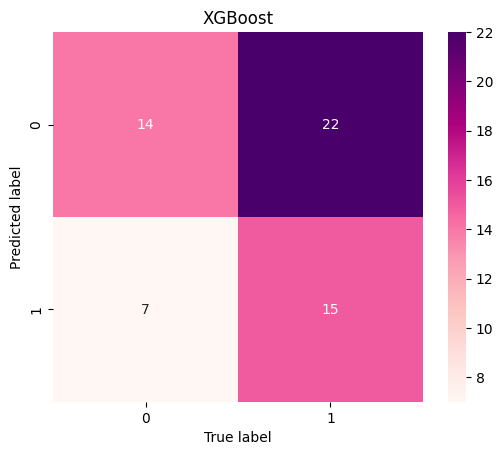

Accuracy:	0.500000
F1-score:	0.508475
Precision:	0.681818
Recall:		0.405405

Classification performance:
              precision    recall  f1-score   support

           0       0.39      0.67      0.49        21
           1       0.68      0.41      0.51        37

    accuracy                           0.50        58
   macro avg       0.54      0.54      0.50        58
weighted avg       0.58      0.50      0.50        58



In [83]:
mat_xgb = confusion_matrix(y_new_season_full, y_pred_new_season_xgb)
sns.heatmap(mat_xgb.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("XGBoost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y_new_season_full, y_pred_new_season_xgb))
print("F1-score:\t%f" % f1_score(y_new_season_full, y_pred_new_season_xgb))
print("Precision:\t%f" % precision_score(y_new_season_full, y_pred_new_season_xgb))
print("Recall:\t\t%f" % recall_score(y_new_season_full, y_pred_new_season_xgb))
print("\nClassification performance:\n%s" % classification_report(y_new_season_full, y_pred_new_season_xgb))

### 5. CatBoost 

In [84]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb

In [85]:
df_bat= pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/halftime_dataframe_R.csv')
df_bat

columns_to_keep = ['Result', "match_number", "team", "opponent", 
                   "gender", 'season', 'home_advantage', 'venue_city',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df = df_bat[columns_to_keep]

print(df.shape)

(115, 12)


In [86]:
df_2023_bat = pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/prediction_set_halftime_model.csv')
df_2023_bat

columns_to_keep = ['Result', "match_number", "team", "opponent", 
                   "gender", 'season', 'home_advantage', 'venue_city',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df_2023 = df_2023_bat[columns_to_keep]

print(df_2023.shape)

(58, 12)


In [87]:
# Transforming the 'Result' column to binary format
df['Result'] = df['Result'].apply(lambda x: 1 if x == 'win' else 0)
df_2023['Result'] = df_2023['Result'].apply(lambda x: 1 if x == 'win' else 0)

# Splitting the data into X (features) and y (target)
X = df.drop(columns=['Result'])
y = df['Result']

X_new_season = df_2023.drop(columns=['Result'])
y_new_season = df_2023['Result']

# List of categorical features
cat_features = [
    'team', 'opponent', 'gender', 'home_advantage', 'venue_city', 'last_match_result'
]

/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_49194/2519307901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Result'] = df['Result'].apply(lambda x: 1 if x == 'win' else 0)
/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_49194/2519307901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['Result'] = df_2023['Result'].apply(lambda x: 1 if x == 'win' else 0)


In [88]:
#Best parameters for CatBoost:  {'depth': 5, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}

model = CatBoostClassifier(
    depth=5, 
    l2_leaf_reg=1, 
    iterations=500, 
    learning_rate=0.1,
    cat_features=cat_features,
    verbose=0  
)
model.fit(X, y)

y_prob_new_season_catboost = model.predict_proba(X_new_season)[:, 1]
y_pred_new_season_catboost = (y_prob_new_season_catboost > 0.5).astype(int)

print("\nPredicted Probabilities for CatBoost in 2023 new season:")
print(y_prob_new_season_catboost)


Predicted Probabilities for CatBoost in 2023 new season:
[1.79081668e-01 4.64396432e-01 7.45420048e-02 3.04251240e-01
 9.99528128e-01 3.67028035e-02 8.44140101e-02 5.95062542e-01
 9.98714246e-01 2.44299720e-02 5.43469247e-01 2.31749904e-01
 4.41088729e-02 3.32247420e-01 8.37126100e-01 9.15444447e-02
 3.74393174e-01 8.79609872e-01 8.39229358e-01 4.82669126e-01
 6.04349398e-01 8.90009558e-01 1.27104871e-01 2.01745950e-01
 9.91353035e-01 9.43415797e-01 5.80775234e-01 8.68432244e-02
 6.14682919e-01 3.66077582e-01 1.60444999e-01 8.61141149e-01
 9.99376453e-01 6.90297523e-03 6.22821615e-01 3.59067078e-04
 3.39167642e-01 9.97364292e-01 7.93833028e-01 8.99649573e-01
 3.00413828e-02 7.26185364e-01 4.60871273e-01 9.95373355e-01
 9.94990530e-01 3.82940241e-03 1.37855798e-01 9.78510305e-01
 8.53091146e-01 4.18022205e-01 8.84921913e-01 9.62419954e-01
 1.18577603e-01 9.64099402e-01 1.02732037e-01 5.98951602e-01
 2.75338147e-01 2.46806065e-01]


In [89]:
y_pred_new_season_catboost

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0])

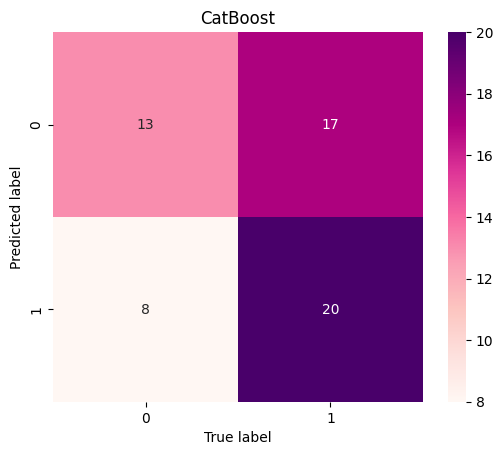

Accuracy:	0.568966
F1-score:	0.615385
Precision:	0.714286
Recall:		0.540541

Classification performance:
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        21
           1       0.71      0.54      0.62        37

    accuracy                           0.57        58
   macro avg       0.57      0.58      0.56        58
weighted avg       0.61      0.57      0.58        58



In [90]:
mat_catboost = confusion_matrix(y_new_season, y_pred_new_season_catboost)
sns.heatmap(mat_catboost.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("CatBoost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y_new_season, y_pred_new_season_catboost))
print("F1-score:\t%f" % f1_score(y_new_season, y_pred_new_season_catboost))
print("Precision:\t%f" % precision_score(y_new_season, y_pred_new_season_catboost))
print("Recall:\t\t%f" % recall_score(y_new_season, y_pred_new_season_catboost))
print("\nClassification performance:\n%s" % classification_report(y_new_season, y_pred_new_season_catboost))